<a href="https://colab.research.google.com/github/scotthou94/applied_deep_learning/blob/master/hw3_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hw3-P2
In this part, we need to use transfer learning and a small user input to train an accurate classifer.
Steps
1. Import a pretrained model (VGG16) and only use the convolutional base
    1. Question. How to select some layers? E.g. we want to use only the early layers
1. Add fully connected layer on top of the base and freeze the base
1. Train the model based on user data (which is small)
1. Evaluate the model. High accuracy is expected.

In [0]:
from __future__ import print_function

import os, sys
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

### Get data

In [3]:
# Prepare data
! curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
! tar xzf flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  52.6M      0  0:00:04  0:00:04 --:--:-- 52.6M


### Generate Dataset

In [0]:
# From raw image to image tensors
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image.numpy()

# From path to resized image tensor
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [72]:
# Generate datapath and labels
data_path = 'flower_photos'
dirs = os.listdir(data_path)
dirs = dirs[: -1]
pic_path = []
for flower in dirs:
  f = os.listdir(os.path.join(data_path, flower))
  print('{0} has {1} pics'.format(flower, len(f)))
  for pic in f:
    imgpath = os.path.join(data_path, flower, pic)
    pic_path.append(imgpath)
print(len(pic_path))
print(pic_path[0])

tulips has 799 pics
sunflowers has 699 pics
dandelion has 898 pics
daisy has 633 pics
roses has 641 pics
3670
flower_photos/tulips/2489638840_72ff3ee527_n.jpg


In [85]:
def getmapping(path, mapping):
  flower = path.split('/')[1]
  if flower in mapping:
    return mapping[flower]

mapping = {'tulips': 0, 'sunflowers': 1, 'dandelion': 2, 'daisy': 3, 'roses': 4}
label = []
X = []
for p in pic_path:
  label.append(getmapping(p, mapping))
  X.append(load_and_preprocess_image(p))
print(label[:10])
print(pic_path[:10])

X = np.array(X)
label = np.array(label)
print(X.shape)

[0, 0, 3, 1, 0, 3, 0, 3, 0, 1]
['flower_photos/tulips/5674125303_953b0ecf38.jpg', 'flower_photos/tulips/7069622551_348d41c327_n.jpg', 'flower_photos/daisy/3625257860_33efeef614_m.jpg', 'flower_photos/sunflowers/3815322974_52c12dbde3.jpg', 'flower_photos/tulips/13910479407_936fd3122d.jpg', 'flower_photos/daisy/5135131051_102d4878ca_n.jpg', 'flower_photos/tulips/8668974855_8389ecbdca_m.jpg', 'flower_photos/daisy/2480569557_f4e1f0dcb8_n.jpg', 'flower_photos/tulips/13910737760_c71c8b6ff2.jpg', 'flower_photos/sunflowers/5042785753_392cc4e74d_n.jpg']
(3670, 192, 192, 3)


In [95]:
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(X, label, test_size=0.1, shuffle=True)
print(x_train.shape, x_val.shape, x_train.dtype)
print(y_train.shape, y_val.shape, y_train.dtype)

(3303, 192, 192, 3) (367, 192, 192, 3) float32
(3303,) (367,) int64


In [159]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(192,192,3))
conv_base.trainable = False

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.00005),
              metrics=['accuracy'])

model.summary()
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_41 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_96 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 5)                 5125      
Total params: 33,595,205
Trainable params: 18,880,517
Non-trainable params: 14,714,688
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              

In [160]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train,
                                     y=y_train,
                                     batch_size=batch_size)

validation_generator = test_datagen.flow(x_val, y=y_val, batch_size=10)

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train)/batch_size,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=len(x_val)/10)

Epoch 1/10
103/103 [==============================] - 78s 762ms/step - loss: 1.0207 - acc: 0.5987 - val_loss: 0.7918 - val_acc: 0.7139
Epoch 2/10
103/103 [==============================] - 78s 761ms/step - loss: 0.7299 - acc: 0.7377 - val_loss: 0.6497 - val_acc: 0.7444
Epoch 3/10
103/103 [==============================] - 78s 761ms/step - loss: 0.6496 - acc: 0.7635 - val_loss: 0.6355 - val_acc: 0.7528
Epoch 4/10
103/103 [==============================] - 78s 760ms/step - loss: 0.5985 - acc: 0.7861 - val_loss: 0.5859 - val_acc: 0.7861
Epoch 5/10
103/103 [==============================] - 78s 761ms/step - loss: 0.5444 - acc: 0.7990 - val_loss: 0.5587 - val_acc: 0.7833
Epoch 6/10
103/103 [==============================] - 78s 760ms/step - loss: 0.5110 - acc: 0.8116 - val_loss: 0.6569 - val_acc: 0.7722
Epoch 7/10
103/103 [==============================] - 79s 765ms/step - loss: 0.4994 - acc: 0.8216 - val_loss: 0.5839 - val_acc: 0.7972
Epoch 8/10
103/103 [==============================] - 7

In [162]:
# Fine-tuning
for layer in conv_base.layers:
  if 'block5' in layer.name:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.000005),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train)/batch_size,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=len(x_val)/10)

Epoch 1/10
103/103 [==============================] - 79s 764ms/step - loss: 0.3636 - acc: 0.8682 - val_loss: 0.5270 - val_acc: 0.8083
Epoch 2/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3665 - acc: 0.8613 - val_loss: 0.5363 - val_acc: 0.8028
Epoch 3/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3526 - acc: 0.8672 - val_loss: 0.5226 - val_acc: 0.8056
Epoch 4/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3530 - acc: 0.8766 - val_loss: 0.5263 - val_acc: 0.8083
Epoch 5/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3275 - acc: 0.8811 - val_loss: 0.5259 - val_acc: 0.8083
Epoch 6/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3599 - acc: 0.8709 - val_loss: 0.5245 - val_acc: 0.8056
Epoch 7/10
103/103 [==============================] - 78s 761ms/step - loss: 0.3339 - acc: 0.8850 - val_loss: 0.5180 - val_acc: 0.8056
Epoch 8/10
103/103 [==============================] - 7

### Evaluation

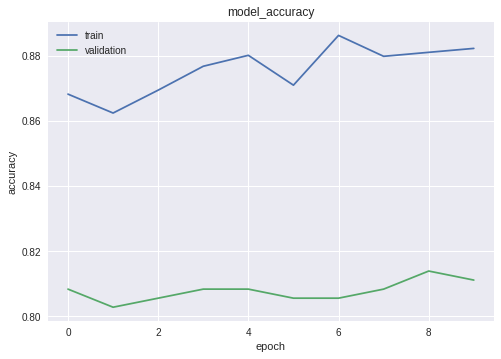

In [165]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

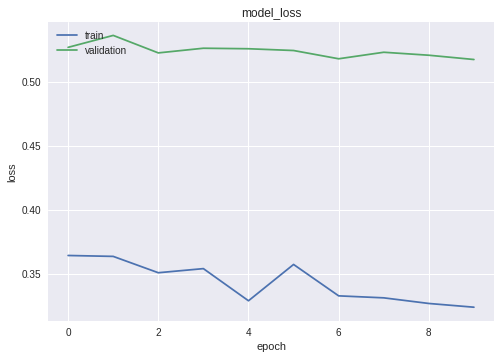

In [166]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### Predict

In [0]:
predict = X[:10]
tlabel = label[:10]
cap = ['tulips', 'sunflowers', 'dandelion', 'daisy', 'roses']

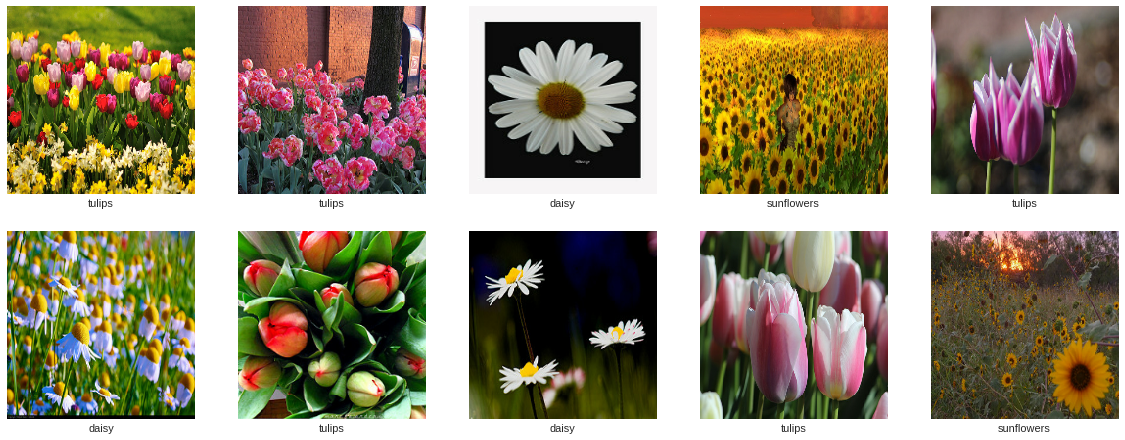

In [176]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predict[i])
    plt.xlabel(cap[tlabel[i]])

In [0]:
predictions = model.predict(predict)

In [181]:
result = np.argmax(predictions, axis=1)
result = [cap[a] for a in result]

['tulips',
 'tulips',
 'daisy',
 'sunflowers',
 'tulips',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'sunflowers']

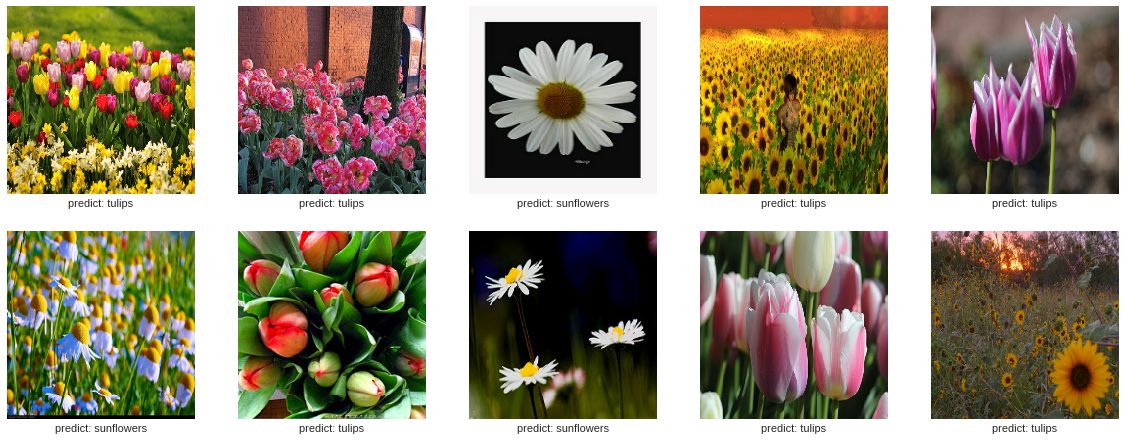

In [183]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predict[i])
    plt.xlabel('predict: ' + result[tlabel[i]])